<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/nbooks/4_normal_hierarchical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [11]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [8.0, 3.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0,
})

# Normal Hierarchical  Models

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale.


* Higher popularity usually means the song has been played often, especially  recently.

# Research questions


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much does popularity vary from song to song?


*  We look for answers with a quantification of the uncertainty.

# Hierarchical data set

* The data set  comprises  one or more songs for each of the 44 artists


* The list of artists  is a  sample from the whole population of  artists that have songs on Spotify

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=1UdgWjLmXW_aO1p-Z5PLsGni7TL9_I-hv' width='700'>
</div>




# The structure of the data

* The $j$ subscript refers to the $j$-th  artist (we have 44 artists).

*  $n_j$: number of songs created by artist $j$.

*  $y_{ij}$:  popularity of the $i$-th song of artist $j$
    * $j \in \{1,2,…,44\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  44 *sub-populations* (or *clusters*);   each artist provides a cluster of songs.

In [12]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song,
#author and popularity.
#The data set contains 350 songs by 44 artists
url = "https://raw.githubusercontent.com/gcorani/bda/refs/heads/main/nbooks/data/spotify.csv"
spotify = pd.read_csv(url)

#spotify = pd.read_csv("/content/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [51]:
# we create a list containing the  name of each artist: ['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]
spotify["artist"] = spotify["artist"].astype("category")
artists = list(spotify["artist"].cat.categories)

#show the first artists
artists[0:5]

350

# Mean popularity of each artist

In [14]:
# artist_popularity contains the mean popularity of the songs of each artist and the name of the artist
# artist ranked from the less popular one.
#we drop the title
spotify = spotify[ ["artist","popularity" ]]
artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

<ipython-input-14-9bfbe70e08eb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()


,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [15]:
# Number of the songs of each artists; it varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count()
artist_count.head()

<ipython-input-15-4bd90b720afe>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  artist_count=spotify.groupby(['artist']).count()


,popularity
artist,
Alok,19
Atlas Genius,4
Au/Ra,5
BUNT.,3
Beyoncé,25


# Pooled and unpooled model

* *Pooled*: merge  data from songs of all artists, without modelling the difference between artists.
     
     
* *Unpooled*:  independently analyzes the songs of every  artist
    * the mean popularity of songs from artist j is $\mu_j$
    * inference about artists with  few published songs is  uncertain
    * cannot predict a novel artist

# Hierarchical model (a.k.a. partial pooling)

* Artist $j$ has its own  mean popularity of songs, $\mu_j$   
    
       
* $\mu_j$ is a sample from the population of the mean popularity of the artists.


*  $\mu'$ and $\sigma_p$ are the mean  and the std deviation of the mean popularity within the *whole* population of artists (not only the 44 artists in our data set).
    
    
* We will assign priors to $\mu'$ and $\sigma_p$.







# Hierarchical model (partial pooling)

* It places a prior on the parameters of the prior (*hierarchical*).
    
       
* It can make prediction also for an artist for which there are no songs in our sample, based on what it has learned about the populations of artists. Moreover, it  improves the estimates for artists with few songs.






# Pooled model

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=18ZXOpZ-nPKSYBz0rgsSxHNVI9dOQ7d6T' width='400'>
</div>


*  We fit a  normal-normal model  on all  songs in the sample (density  shown in the plot), ignoring the grouping structure implied by the different authors.


# Pooled model

* We fit a normal-normal model on  the data set containing all songs:

  
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(\xi)\\
\vec{y_{ij}} & \sim N(\mu, \sigma)
\end{align*}

*  $\mu$ and $\sigma$ are   *global* parameters, which apply to every song.

* $\mu'$ and  $\sigma_{\mu}$ are fixed numbers which are  represent some  prior knowledge.


# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (30, 70).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(\underbrace{50}_{\mu'}, \underbrace{10}_{\sigma_{\mu}}) $$



# Prior on $\sigma$

In [16]:
# sigma controls the spread of popularity in the whole population of songs
# We can interpret the range (0 , 100) as a range with length 4 stds (+-2 std around the mean).
# Thus a plausible value of  sigma is  25.
#This is slightly in excess, as some density is outside the allowed range (0,100).

# Using  scale 36, we get the median of the distribution close to 25.
from scipy.stats import halfnorm
pd.DataFrame(halfnorm.rvs(scale=36, size=10000)).describe()

,0
count,10000.000000
mean,28.907927
std,21.774580
min,0.005977
25%,11.770519
50%,24.481657
75%,41.423314
max,137.738299


# Prior predictive check

* Does our prior make really sense?

* To check how the prior on $\mu$ and $\sigma$ interact, let's simulate from the prior.

* The model does not structurally bound the values between 0 and 100. We can thus check the quantiles of the simulated data and possibly adjust the prior on $\sigma$ (the prior on $\mu$ is more stable).


In [17]:
import numpy as np
from scipy.stats import norm, halfnorm

prior_samples = 10000

#10000 samples from the normal-normal model with halfnorm 36:
# we sample the mean, then the sigma and then generate the samples as N(mu_s, sigma_s)
# as prior predictive check, we check the quantiles of the data simulated from the prior
mu_s = norm.rvs(loc = 50, scale = 10, size = prior_samples)
s_s = halfnorm.rvs(scale = 36, size = prior_samples)
y_s = norm.rvs(loc = mu_s, scale = s_s)

#percentiles 1, 50, 99
pc = np.percentile(y_s, q=np.array([1,  50, 99]))
#array([-51.79,  50.63, 154.88])


# we shall restrict the prior on the standard deviation
mu_s = norm.rvs(loc = 50, scale = 10, size = prior_samples)
s_s = halfnorm.rvs(scale = 20, size = prior_samples)
y_s = norm.rvs(loc = mu_s, scale = s_s)
pc = np.percentile(y_s, q=np.array([1,  50, 99]))
#array([-11.92,  50.20, 112.23])
# a further decrease of scale is needed


mu_s = norm.rvs(loc = 50, scale = 10, size = prior_samples)
s_s = halfnorm.rvs(scale = 17, size = prior_samples)
y_s = norm.rvs(loc = mu_s, scale = s_s)
pc = np.percentile(y_s, q=np.array([1,  50, 99]))
#array([ -3.8,  50.05, 103.2])
#good! It is ok to be slightly beyond the domain.


# Pooled model

* According to the prior predictive check we adopt a scale of 17 for the half-normal. This is a lower scale compared to our initial guess.

* Simulating from data is a good way to have a tenable  prior.

\begin{align*}
\mu    & \sim N(50, 10) \\
\sigma & \sim\text{HalfNormal} (17) \\
\vec{y_{ij}}  & \sim N(\mu, \sigma) \\
\end{align*}

In [18]:
with pm.Model() as pooled_model:
    # prior
    # we use the name global_mean and global_sigma to show that they refer to the entire population of songs
    global_mean    =  pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 17)

    #likelihood
    popularity       =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    trace_pooled     = pm.sample(return_inferencedata=True)

Output()

Output()

In [19]:
# The Spotify songs have an average popularity of about 58.
# There is  a  large standard deviation  (global_sigma) of popularity  from song to song.
# The data set has large variability, as it contains songs from different authors.
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.346,1.140,56.329,60.488,0.026,0.018,1928.0,1383.0,1.0
global_sigma,20.685,0.802,19.218,22.125,0.018,0.012,2073.0,1555.0,1.0


# Quiz yourself

* How would you make  a prediction using the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) in the sample?
    * Beyoncé, the artist with the highest mean popularity (70) in the sample?
    * a group not present in the sample?
   

# Answer
* The   pooled model ignores the artist; the prediction for the popularity of a new song is the same for  every author.

* It requires computing the *predictive distribution*.

# Predicting the popularity of the next song (*predictive distribution*)

* The trace contains 4000 parameter samples  $<\mu_s, \sigma_s>$.

* For each sample  we draw  a possible future value of popularity as:

$$
y_s^{\text{new}}  \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$


$$
\left[
\begin{array}{ll}
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * *epistemic* uncertainty about  the values of $\mu, \sigma$ (in principle reducible by collecting more data)
   * *aleatory* uncertainty (irreducible) due to stochastic sampling, given a specific value of $\mu$ and $\sigma$.

In [41]:
#prediction distribution of the  pooled model
post_pooled   =  az.extract(trace_pooled.posterior)

#posterior samples
mu         = post_pooled.global_mean.values
sigma      = post_pooled.global_sigma.values

#samples for each mu-sigma pair
new_samples = 100
y_new = np.zeros(len(mu) * new_samples)

for i, current_mu in enumerate(mu):
        y_new[i*new_samples : ((i+1) * new_samples)] = np.random.normal (size = new_samples, loc = mu[i], scale = sigma[i])
        #y_new[i]   = np.random.normal (loc = mu[i], scale = sigma[i])

print('summary of predictive distribution: \n')
print(pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975]))

summary of predictive distribution: 

                   0
count  200000.000000
mean       58.291540
std        20.712422
min       -39.159209
2.5%       17.690462
50%        58.262888
97.5%      98.886325
max       166.641827


# Computing the prediction in pymc

* More convenient, but less instructive than computing it by ourselves starting from the trace.

In [21]:
#predictive distribution implemented in pymc

with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 17)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])

    #prediction, computed for every posterior sample of global_mean and global_sigma.
    predictive         =  pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Output()

Output()

In [22]:
#this prediction is the same for every artist.
az.summary(trace_pooled, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,57.916,21.243,18.971,97.687,0.372,0.277,3264.0,1530.0,1.0


# Unpooled model

* It independently analyzes the songs of each artist.


* The  mean popularity of the $j$-th artist is  $\mu_j$.


* One artist’s mean doesn’t tell us anything about another’s.

# Unpooled model

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=1kg2r3BQxTE8hvMNBBGE2ilxhG7g1elqL' width='500'>
</div>


* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.

* We assume no prior relation between the $\mu_j$, which are independent from each other.

* We assume   $\sigma$ to be common to all artists.


      



# About the common sigma

* This  assumption of a common $\sigma$ is reasonable and simplifies the inference (we have 45 parameters rather than 88).


* It could be  worth implementing also a  model with a different $\sigma$ for each artist and comparing the two models (we will discuss model selection  later in the course).


# Adapting the priors to the unpooled model

* The prior on the mean was $\mu \sim N(50, 10)$ for the pooled model; it represents our beliefs about the center of the population.

* Now we have instead to define the  priors for  $\mu_j$, the mean popularity of each artist.

* We assume  $\mu_j$ to possibly vary in (10, 90). Interpreting this as a 95% interval, the prior of each $\mu_j$ is: $$\mu_j \sim N(50, 20)$$.


* It is also necessary reducing   $\sigma_{\text{songs}}$:

  * in the unpooled model $\sigma_{\text{songs}}$ represents variability between  songs from the same artists;

  * in the previous pooled model $\sigma_{\text{songs}}$ represents variability between  songs within the entire spotify;
  
  * we adjust it via prior predictive check.



In [48]:
# prior predictive check to set the sigma of unpooled model

# this function samples from the prior, given a scale for the half normal.
# return the percentile 1, 55, 99 of the sampled data.
def test_sigma(half_normal_scale):
  # simulate a vector of means from the prior of the mean
  mu_s = norm.rvs(loc = 50, scale = 20, size = 10000)

  # simulate a vector of stds from the prior of sigma, with the given scale
  s_s = halfnorm.rvs(scale = half_normal_scale, size = 10000)

  # simulate a value from each pair (mu, sigma)
  y_s = norm.rvs(loc = mu_s, scale = s_s)

  #return the percentile 1, 50, 99
  pc = np.percentile(y_s, q=np.array([1,  50, 99]))

  return pc

# the sigma of the pooled model yields too many values outside the domain
print("scale = 17: " + str(test_sigma(half_normal_scale=17))) # too large
print("scale = 15: " + str(test_sigma(half_normal_scale=15))) # still too large
print("scale = 12: " + str(test_sigma(half_normal_scale=12))) # still too large
print("scale = 10: " + str(test_sigma(half_normal_scale=10))) # ok, only slightly beyond the domain boundaries

scale = 17: [-14.33052204  50.39151749 114.17795613]
scale = 15: [-11.5124826   50.45517459 112.01468546]
scale = 12: [ -5.08962841  50.37249714 104.64565778]
scale = 10: [ -2.69186711  49.61559994 103.98585674]


# Unpooled model

* Having decided the scale of the half-normal via prior predictive check, the model is:

\begin{align*}
\mu_j    & \sim N(50, 20)  \; \; \; j=1,2...44\\
\sigma_{\text{songs}} & \sim \text{HalfNormal}(10) \\
y_{ij}  & \sim N(\mu_j, \sigma_{\text{songs}}) \\
\end{align*}



In [24]:
#to see the structure of the data
spotify

,artist,popularity
0,Alok,79
1,Alok,56
2,Alok,75
3,Alok,65
4,Alok,52
...,...,...
345,Zeds Dead,58
346,Zeds Dead,44
347,Zeds Dead,54
348,Zeds Dead,49


In [25]:
#The code below assigns a  numerical code to each author; then it assigns to each song the code of its author.
n_artist = len(artist_count) #44

#names of the authors of each song
artist       = spotify['artist'].values

#names mapped into codes
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes


# we now identify the code of Beyonce and BUNT.
# we use item() to convert the np array into a scalar.
beyonce_code = np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']).item()
bunt_code    = np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']).item()

# we count how many songs from Beyoncé and BUNT.
print('songs from Beyoncé: ', np.sum(spotify['artist'] == 'Beyoncé'));
print('songs from BUNT.: ', np.sum(spotify['artist'] == 'BUNT.'));

songs from Beyoncé:  25
songs from BUNT.:  3


In [49]:
with pm.Model() as unpooled_model:
    # A vector of independent means, one for each artist.
    # Using the keyword 'shape' we instantiate a vector of parameters.
    mu_artist        =  pm.Normal ('mu_artist', 50,  20, shape = n_artist)

    # std dev of the popularity of song produced by the same artist, the same for all artists.
    sigma_songs    =  pm.HalfNormal ('sigma_songs', sigma = 10)

    #spotify["popularity"] is the vector of popularities of each song;
    #spotify['artist_code'] is a vector containing the code of the author of each song.
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    trace_unpooled  = pm.sample(cores=1)

Output()

Output()

In [27]:
# posterior mean of each artist (only the first ones are shown).
#The mean is different for each artist.
# The uncertainty about the posterior mean is represented by the length of its HDI.
# Artist with many songs (like Beyoncé) have shorter HDI compared to artists with less songs(like BUNT.)

# assing_coords is  used to assign  the artist name to each element of the vector mu_artist, and show the names in the summary.
posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[Alok],64.465,3.092,58.750,70.208,0.047,0.033,4406.0,1442.0,1.0
mu_artist[Atlas Genius],46.348,6.577,33.843,58.663,0.098,0.073,4483.0,1362.0,1.0
mu_artist[Au/Ra],59.843,5.723,49.313,70.432,0.095,0.067,3664.0,1507.0,1.0
mu_artist[BUNT.],43.320,7.094,29.729,56.163,0.099,0.071,5113.0,1507.0,1.0
mu_artist[Beyoncé],69.309,2.826,63.940,74.436,0.038,0.027,5503.0,1441.0,1.0


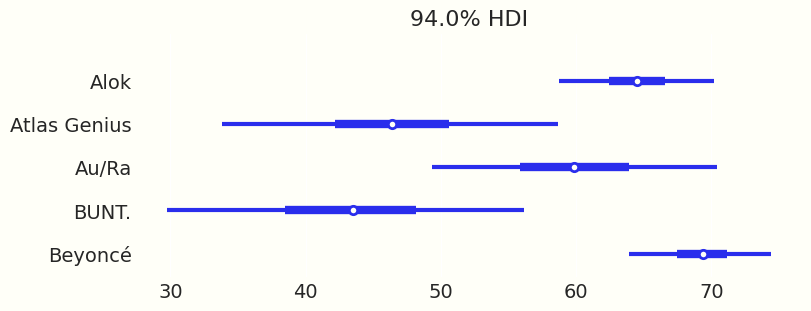

In [28]:
# The forest plot compares HDI intervals of different distributions (different artists in our case).
# The HDIs are shorter for artists that have published more songs.
# We show only the first 5 artists: we limit and label the graph using the coords option.
axes = az.plot_forest (trace_unpooled, var_names="mu_artist",
                       combined=True, # a single plot for each artist,  merging  samples from different chains.
                       coords={"mu_artist_dim_0": range(5)}, figsize=(8, 3))
artists_5 = artists[:5]
axes[0].set_yticklabels(artists_5[::-1]);

In [29]:
# the global_sigma represents the variations between songs produced by the same artist.
# It is the same for every artist.
# It is lower compared to the pooled model, as it only accounts for variations between songs of the same artists.
az.summary(trace_unpooled, var_names='sigma_songs')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_songs,13.995,0.57,12.955,15.078,0.01,0.007,3273.0,1640.0,1.0


# Predictive distribution for the next song of Beyoncé

* For each  posterior samples $<\mu_{\text{Beyoncé},s}, \sigma_s>$:
    * sample $y_{\text{Beyoncé},s}^{\text{new}}$ from a normal distribution.

$$
\left[
\begin{array}{ll}
\mu_{\text{Beyoncé},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{Beyoncé},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

# Predictive distribution of Beyoncé and BUNT in Pymc

In [30]:
#predictive distribution for the next song of Beyoncé in Pymc3

with pm.Model() as unpooled_model_with_preds:

    #lines below as in the unpooled model
    mu_artist       =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    sigma_songs     =  pm.HalfNormal ('sigma_songs', sigma = 36)
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    #predictive distribution of Beyonce and Bunt
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = sigma_songs)
    pred_bunt   = pm.Normal ('pred_bunt', mu = mu_artist[bunt_code],  sigma = sigma_songs)

    trace_unpooled_with_preds  = pm.sample(return_inferencedata=True)

Output()

Output()

In [31]:
# Predictive distribution of Beyonce and Bunt
#There is larger uncertainty in the  predictive distribution than
# in the posterior mean

# Moreover, there is more uncertainty (see the sd) for  Bunt than for Beyoncè.
az.summary(trace_unpooled_with_preds, var_names=['pred_beyonce','pred_bunt'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.512,14.479,40.104,97.387,0.206,0.153,4972.0,1337.0,1.0
pred_bunt,43.179,16.114,12.280,73.994,0.273,0.200,3456.0,1774.0,1.0


# Discussion

* Posterior mean popularity of Beyoncé:

  * The HDI is between the .025 and .975 percentile of the posterior samples of $\mu_{\text{Beyoncé}}$

* Predictive distribution for the next song by Beyoncé:

  * The HDI is between the .025 and .975 percentile of the samples $y^{\text{new}}_{\text{Beyoncé}}$, which are generated by sampling from $N(\mu_{\text{Beyoncé}}, \sigma)$

# Shortcoming of the unpooled model


* estimates for artists with few songs are  uncertain

    
* it  does not model the *population* of  artists. Even though we have analyzed 44 artist, we are unable to say anything about another  Spotify artist not  present in our data set.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
& \mu_{\text{pop}} & \sim N(\mu_{\text{hier}}, \sigma_{\text{hier}}) \;\;\;
\text{prior beliefs about popularity of the artist in the population} \\
& \sigma_{\text{pop}} & \sim HN(\xi_{hier})  \;\;\;
 \text{prior beliefs about std of artist popularity in the population} \\
 \\
 & \mu_j & \sim N( \mu_{\text{pop}}, \sigma_{\text{pop}})  \;\;\;  \text{ $\mu_j$ is a sample from the population of artists}\\
 & \sigma_{\text{songs}} & \sim HN(\xi)  \;\;\; \text{same prior of the unpooled model }  \\
\\
 & y_{ij} & \sim N( \mu_j, \sigma) \;\;\;  \hspace{-0.075in} \text{distrib of  popularity of the songs of artist } j
\\
\end{array}
\end{equation}

* There is a prior over the parameters of the prior of $\mu_j$, which which are instead fixed numbers in the unpooled model.

* Those prior allow learning the mean and standard deviation of the population of artists.

# Individual songs for each artist.

* As in the unpooled model,  the popularity of songs  of  artist $j$ are distributed:

$$  y_{ij} \sim N(\mu_j, \sigma_{\text{songs}}) $$

* $\mu_j$: mean popularity of the songs by artist $j$



# Modeling the population of artists

$$ \mu_j \sim N(\mu_{\text{pop}}, \sigma_{\text{pop}}) $$


* We want to learn the population of artists.
  
* Both $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$ are  *parameters*, to which we will assign a prior.

# Recap

* $\mu_{\text{pop}}$: mean popularity of the artists, within the population of artists


* $\sigma_{\text{pop}}$ standard deviation of the popularity of the artists, i.e., of the  $\mu_j$.


*  $\mu_j$: popularity of artist $j$, i.e.,  mean popularity of songs from the artist $j$.  

* $\sigma_{\text{songs}}$:  standard deviation of popularity between songs from the same author.


# Priors for  $\mu_{\text{pop}}$ and  $\sigma_{\text{pop}}$

\begin{align*}
\mu_{\text{pop}}    & \sim N(50, 10) && \text{the population mean is comprised within prob 0.95 in 30 - 70} \\
\sigma_{\text{pop}} & \sim \text{Half Normal}(15)    && \text{tuned via prior pred check}\\
\end{align*}

* The scale of the halfnorm is tuned to have the priors widely spread in 0-100.

In [53]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:

    # prior on the parameters of the population of artists (hyper-priors).

    # prior beliefs about the mean value and the spread of the different mu_j
    #This is where the hierarchical model differs from the unpooled model.
    mu_pop     = pm.Normal ('mu_pop', 50,  10)
    sigma_pop  = pm.HalfNormal ('sigma_pop', 15)


    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist   =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_pop, shape= n_artist)

    # spread between songs of the same authors) is as in the unpooled model.
    sigma_songs  =  pm.HalfNormal ('sigma_songs', sigma = 17)

    #Popularity of each song is a sample from N(mu_j, sigma_songs).
    popularity   =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    #predictive distribution of Beyoncè
    #this is not needed to fit the model. It is useful however to illustrate
    #the difference between unpoled and hierarchical model.
    #This line of code is identical to that of the unpooled model.
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = sigma_songs)
    pred_bunt   = pm.Normal ('pred_bunt', mu = mu_artist[bunt_code],  sigma = sigma_songs)



    trace_hier   = pm.sample(return_inferencedata=True)

Output()

Output()

In [54]:
#mu_pop is indeed close to 50 as we assumed
#the 95% popularity of the artists varies in roughly 52 +- 30
#the songs of a given author are comprised with 95% probability within a range of +-28 around its mean.
az.summary(trace_hier, var_names=["mu_pop", "sigma_pop", "sigma_songs", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,52.400,47.749,57.067,1.0
sigma_pop,15.036,11.461,18.493,1.0
sigma_songs,14.022,12.897,15.050,1.0
mu_artist[0],64.287,58.153,70.011,1.0
mu_artist[1],47.074,35.205,58.397,1.0


In [35]:
# here we compare the predictions made by the hierarchical and the unpooled model
# for Beyonce and Bunt.
# Beyonce has many songs and the hierarchical model revises only slightly downwards its mean
# popularity compared to the unpooled model.
# BUNT has few songs with low score, and the hierarchical models increases the
# estimate of its popularity by a couple of points compared to the unpooled model.
# In general the hierarchical model produces estimates that push the unpooled estimates  towards
# the mean of the population.


hier_pred_summary=az.summary(trace_hier, var_names=["pred_beyonce", "pred_bunt"])
unpooled_pred_summary=az.summary(trace_unpooled_with_preds, var_names=["pred_beyonce", "pred_bunt"])
pd.concat([hier_pred_summary, unpooled_pred_summary])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.112,14.369,42.128,94.674,0.229,0.166,3963.0,1812.0,1.0
pred_bunt,44.964,15.637,14.912,73.115,0.253,0.186,3840.0,1540.0,1.0
pred_beyonce,69.512,14.479,39.464,94.183,0.206,0.153,4972.0,1337.0,1.0
pred_bunt,43.179,16.114,13.818,73.465,0.273,0.200,3456.0,1774.0,1.0


In [36]:
# preparing the traces, to be able to access using names.
#this way the name of the artist is assigned to each mu_j
#the trace object has an internal field called mu_artist_dim_0
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

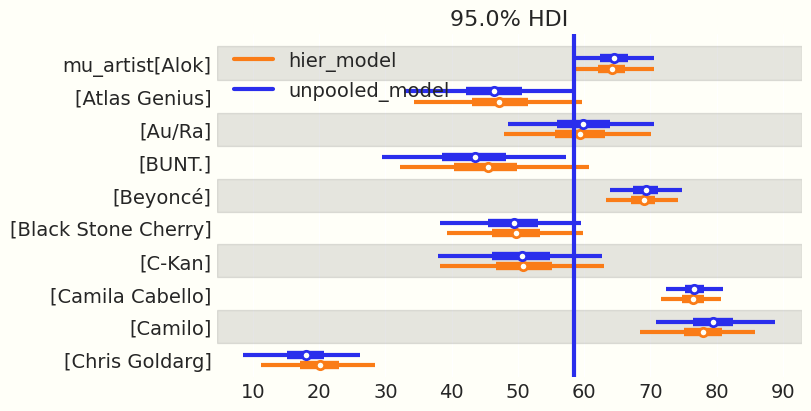

In [37]:
#estimated mean popularity of each artist, according to the unpooled and to the hierarhical model
# the expected values of the hierarchical model are pulled towards to general mean (shrinkage).
axes = az.plot_forest([trace_unpooled, trace_hier],
                      model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": artists[0:10]},  figsize=(8, 4));
#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

# The hierarchical model pulls the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist.


*  The unpooled model separately analyzes each artist ignoring the information about the grand mean.


* The hierarchical model pulls  the estimates of the unpooled model  towards the grand mean (*shrinkage*).


# Shrinkage

* Given $\sigma_{\text{songs}}^2$ and  $\sigma^2_{\text{pop}}$, the posterior mean of the hierarchical model for  artist $j$  is a compromise between the posterior mean of the pooled and the unpooled model:

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma_{\text{songs}}^2}{\sigma_{\text{songs}}^2 + n_j \sigma^2_{\text{pop}}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} +
\underbrace{
\frac{n_j\sigma^2_{\text{pop}}}{\sigma_{\text{songs}}^2+ n_j \sigma^2_{\text{pop}}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_{j, \text{unpooled}}
$$

* $\overline{\mu}_{\text{pooled}}$: posterior mean of the pooled model.

* $\overline{\mu}_{\text{unpooled}}$: posterior mean of the unpooled model.

* If $n_j$ is small:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{\text{pooled}}$$

* If $n_j$ is large:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{j, \text{unpooled}}$$


# Shrinkage


* The behavior of the model is in reality more complex as  variances and means are parameters.


* Hence a different weighted sum is computed  for each posterior sample of the trace.

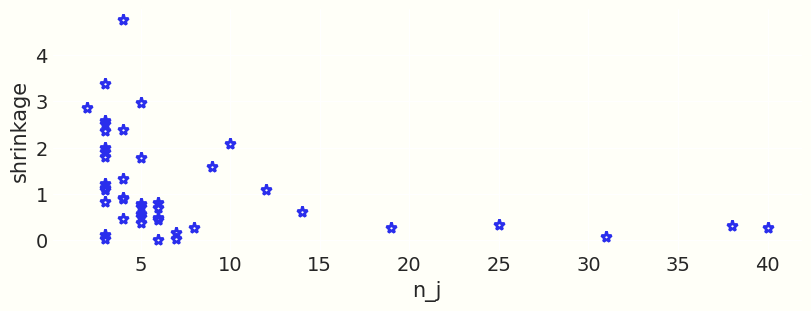

In [38]:
# here we define shrinkage as the difference between the posterior mean of the hierarchical model
# and the unpooled model, in absolute value.
# We show that  shrinkage, in absolute value, decreases with  the number of songs that one  artist has..

n_j = spotify['artist'].value_counts(sort=False)
mean_unpooled = az.summary(trace_unpooled, var_names=["mu_artist"])["mean"]
mean_hier = az.summary(trace_hier, var_names=["mu_artist"])["mean"]

#absolute value of the shrinkage
shrinkage = pd.Series((mean_hier-mean_unpooled).values, index=artists).abs()

df = pd.concat([n_j, shrinkage], axis=1)
df.columns = ["n_j", "shrinkage"]
plt.plot(df["n_j"], df["shrinkage"], "*")
plt.xlabel("n_j")
plt.ylabel("shrinkage");

# Predictive distribution for the next song of a known artist

$$
\left[
\begin{array}{ll}
\mu_{\text{Beyoncé},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{Beyoncé},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

* This works in the same way of the unpooled model,  with the difference that the values of $\mu_{\text{Beyoncé}}$ will be (slightly) pulled towards the general mean.

# Predictive distribution for the first song artist of a new artist

* It requires two sampling steps.


* First we sample possible values of $\mu_{\text{new a}}$ of the new artist from the population of artists.


* Given the samples of $\mu_{\text{new a}}$, we follow the same procedure of the  artists with songs.



# Predictive distribution for the next song of a  **known** artist

* For each posterior sample  $<\mu_{\text{new a},s}, \sigma_s>$, draw a value from $N(\mu_{\text{new a},s}, \sigma_s)$.

$$
\left[
\begin{array}{ll}
\mu_{\text{new a},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{new a},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{new a},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{new a},1} \\
y_{\text{new a},2}\\
\vdots \\
y_{\text{new a},4000}\\
\end{array}
\right]
$$

# Predictive distribution for the first song artist of a new artist

* Requires two steps of sampling.

* We create samples for $\mu_{\text{new a}}$ for the new artist by using the  posterior samples of $\mu'$ and $\sigma_{\mu}$, i.e., by sampling from the population of artists.

$$
\left[
\begin{array}{ll}
\mu_{\text{pop},1} &   \sigma_{\text{pop},1} \\
\mu_{\text{pop},2}  & \sigma_{\text{pop},2} \\
\vdots & \vdots  \\
\mu_{\text{pop},4000}   & \sigma_{\text{pop},4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
\mu_{\text{new a},1} \\
\mu_{\text{new a},2}\\
\vdots \\
\mu_{\text{new a},4000}\\
\end{array}
\right]
$$

# Predictive distribution for the next song of a  known artist

* For each posterior sample  $<\mu_{\text{new a},s}, \sigma_s>$, draw a value from $N(\mu_{\text{new a},s}, \sigma_s)$.

$$
\left[
\begin{array}{ll}
\mu_{\text{new a},1} &   \sigma_{\text{songs, }1} \\
\mu_{\text{new a},2}  & \sigma_{\text{songs, } 2} \\
\vdots & \vdots  \\
\mu_{\text{new a},4000}   & \sigma_{\text{songs, }4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{new a},1} \\
y_{\text{new a},2}\\
\vdots \\
y_{\text{new a},4000}\\
\end{array}
\right]
$$

# Your turn

* Working on the raw samples from the trace, compute:

    * the predictive distribution for the next song of Beyonce and BUNT using  the hierarchical and the unpooled model; comment the results.

    * the predictive distribution for the first song of a a new artist using to the hierarchical model.

    * hint:  use `beyonce_code` as index  for the position Beyonce within mu_artist



# Your turn - 2

* Alicia  invites four friends to  take 20 speed-typing tests of equal difficulty. Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.

* Define a hierarchical model and discuss the meaning of its equations.
    
* Assume that each person is  consistent in his typing times, but there are big differences from person to person.

    * Is  $ \sigma_{tests}$  lower, larger or close to $\sigma_{pop}$?


# Grouping variable or covariate?

* Consider a categorical variable  $X$.


* Should $X$  be modeled  hierarchically  or  treated as a categorical variable (unpooled model)?

    *   if the data covers all categories,  it is better treated as a categorical variable
    
    *  if the observed categories are only a  sample from many possible ones,  the hierarchical approach is recommended.


# Grouping variable or covariate?


* Our data set includes only  44 among thousands of artists on Spotify. Treating artist as a categorical variable (unpooled model) would limit our conclusions  to  this small sample.


* Treating it as a grouping variable (hierarchical model) allows us to learn about the  broader population of artists from which they were sampled.


# Grouping variable or covariate?

* A daily data set of bike-sharing covers two years;  we know whether each day  was a weekday or a weekend.

* The dataset covers both categories, with many observations for each category.

* Hence  it is better treated as a categorical variable (unpooled model).

# Grouping variable or covariate?

* Consider a data set containing math scores  from of 10  Swiss primary schools; this is a  small sample from the hundreds  of schools.


* The unpooled model  learns only about this small sample of schools.


* The hierarchical model   extends its conclusions to the  population of all schools; this is a better modelling choice.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals.

# Solutions

In [39]:
#prediction for Beyonce using the unpooled and the hierarchical model
post_hier         = az.extract(trace_hier.posterior)
mu_beyonce_hier   = post_hier.mu_artist[beyonce_code].values
sigma_songs_hier  = post_hier.sigma_songs.values

post_unpooled     = az.extract(trace_unpooled.posterior)
mu_beyonce_unpooled  = post_unpooled.mu_artist[beyonce_code].values
sigma_songs_unpooled = post_unpooled.sigma_songs.values

y_beyonce_hier     = np.zeros(len(mu_beyonce_hier))
y_beyonce_unpooled = np.zeros(len(mu_beyonce_hier))

for i, current_mu in enumerate(mu_beyonce_hier):
        y_beyonce_hier[i]     = np.random.normal (loc = mu_beyonce_hier[i], scale = sigma_songs_hier[i])
        y_beyonce_unpooled[i] = np.random.normal (loc = mu_beyonce_unpooled[i], scale = sigma_songs_unpooled[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce.
print('hier: ')
print(pd.DataFrame(y_beyonce_hier).describe(percentiles=[0.025, 0.975]))
print('\n\n')

print('unpooled:')
print(pd.DataFrame(y_beyonce_unpooled).describe(percentiles=[0.025, 0.975]))

hier: 
                 0
count  2000.000000
mean     69.492328
std      14.338031
min      25.313690
2.5%     40.918490
50%      69.360452
97.5%    97.563509
max     123.605270



unpooled:
                 0
count  2000.000000
mean     69.428947
std      14.369144
min      16.580509
2.5%     41.786818
50%      69.026130
97.5%    97.282557
max     115.888209


In [40]:
#prediction for a novel artist
post_hier   = az.extract(trace_hier.posterior)

#posterior parameters of the population
mu_population    = post_hier.mu_pop.values
sigma_population = post_hier.sigma_pop.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
sigma_songs = post_hier.sigma_songs.values
popularity_new_song_new_artist  = np.zeros(len(sigma_songs))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = sigma_songs[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
#there is a major increase in the std wrt a known artist such as Beyonce.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])

,0
count,2000.000000
mean,52.877800
std,19.844314
min,-8.629426
2.5%,13.674035
50%,53.167187
97.5%,92.037983
max,120.461526
